In [218]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import hashlib
import matplotlib.ticker as ticker
import scipy as sp
import scipy.stats as stats

from typing import Tuple, Dict, Optional, Set, List
from fitter import Fitter, get_common_distributions, get_distributions
from matplotlib.axes import Axes
from scipy import stats
from tqdm import tqdm


import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [2]:
df = pd.read_csv('experiment_42.csv', sep=";", usecols=['id', 'click', 'view', 'var'])

In [3]:
df.head()

,id,click,view,var
0,4dMaH8wQnr,18,99,A
1,6YGuuP1Tjg,17,20,B
2,iouKOyTKKH,20,38,B
3,P9yRoGtIfj,9,70,B
4,PLUtBt5R4w,12,24,A


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9526 entries, 0 to 9525
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      9526 non-null   object
 1   click   9526 non-null   int64 
 2   view    9526 non-null   int64 
 3   var     9526 non-null   object
dtypes: int64(2), object(2)
memory usage: 297.8+ KB


In [5]:
df.shape[0]

9526

In [6]:
df.groupby("var").id.count()

var
A    4772
B    4754
Name: id, dtype: int64

In [7]:
df.describe()

,click,view
count,9526.000000,9526.000000
mean,12.025404,63.708692
std,7.231238,31.185067
min,0.000000,10.000000
25%,6.000000,36.000000
50%,12.000000,64.000000
75%,18.000000,90.750000
max,24.000000,117.000000


In [8]:
df[df.isnull().any(axis=1)]

,id,click,view,var


In [9]:
df.groupby('id').click.filter(lambda x: len(x) > 1)

Series([], Name: click, dtype: int64)

In [10]:
(df.click / df.view).round(2)

0       0.18
1       0.85
2       0.53
3       0.13
4       0.50
        ... 
9521    0.08
9522    0.17
9523    0.12
9524    0.10
9525    0.12
Length: 9526, dtype: float64

In [319]:
df['ctr'] = (df.click / df.view)

In [320]:
df.describe()

,click,view,ctr
count,9154.000000,9154.000000,9154.000000
mean,11.709307,65.717391,0.231265
std,7.167652,30.136946,0.202173
min,0.000000,10.000000,0.000000
25%,5.000000,40.000000,0.086420
50%,12.000000,66.000000,0.181818
75%,18.000000,91.000000,0.305556
max,24.000000,117.000000,1.000000


In [321]:

df[df.ctr > 1].head()

,id,click,view,var,ctr


In [14]:
df[df.ctr > 1].id.count()

372

Тут видно какая-то аномалия в исходных данных, примерно в 4% от всех данных поюзерный CTR > 1, чего по определению метрики быть не должно. Такие аномалии могут потенциально испортить расчеты, поэтому уберем их из исходных данных

In [15]:
df[df.ctr == 1].id.count()

45

In [16]:
df = df[df.ctr <= 1]

In [17]:
df.shape[0]

9154

In [53]:
df.groupby(['click', 'var']).id.count().head(20)

click  var
0      A      207
       B      171
1      A      186
       B      195
2      A      178
       B      221
3      A      166
       B      203
4      A      201
       B      190
5      A      189
       B      190
6      A      195
       B      188
7      A      195
       B      187
8      A      175
       B      219
9      A      178
       B      177
Name: id, dtype: int64

In [166]:
df.describe()

,click,view,ctr
count,9154.000000,9154.000000,9154.000000
mean,11.709307,65.717391,0.231264
std,7.167652,30.136946,0.202173
min,0.000000,10.000000,0.000000
25%,5.000000,40.000000,0.086400
50%,12.000000,66.000000,0.181800
75%,18.000000,91.000000,0.305600
max,24.000000,117.000000,1.000000


### Изучение исходных данных

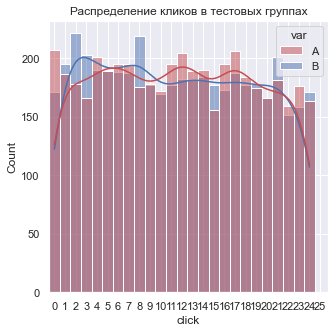

In [299]:
groups = sns.histplot(data = df, 
              x='click', 
              hue='var', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=True, discrete=True)

groups.set_title("Распределение кликов в тестовых группах");

groups.xaxis.set_major_locator(ticker.MultipleLocator(1))
groups.set(xlim=(-0.5, None)) 
groups.xaxis.set_major_formatter(ticker.ScalarFormatter())

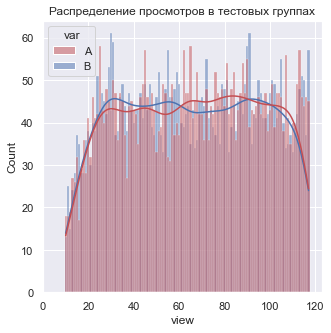

In [298]:
groups = sns.histplot(data = df, 
              x='view', 
              hue='var', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=True, discrete=True)

groups.set_title("Распределение просмотров в тестовых группах");

groups.xaxis.set_major_locator(ticker.MultipleLocator(20))
groups.set(xlim=(0, None)) 
groups.xaxis.set_major_formatter(ticker.ScalarFormatter())

Интересный вид распределения у кликов и просмотров - очень похоже на равномерное распределение

In [341]:
pd.set_option('display.max_rows', 500)

In [305]:
ctr_rounded = df.ctr.round(2)

In [325]:
df.click.value_counts().sort_index()

0     378
1     381
2     399
3     369
4     391
5     379
6     383
7     382
8     394
9     355
10    341
11    372
12    386
13    371
14    374
15    333
16    368
17    393
18    361
19    352
20    332
21    382
22    310
23    334
24    334
Name: click, dtype: int64

In [323]:
df.ctr.value_counts().sort_index()

0.000000    378
0.008547      4
0.008621      4
0.008696      4
0.008772      6
           ... 
0.954545      5
0.956522      4
0.958333      4
0.960000      5
1.000000     45
Name: ctr, Length: 1518, dtype: int64

In [328]:
df.view.value_counts().sort_index()[:50]

10     31
11     43
12     34
13     51
14     54
15     69
16     52
17     57
18     64
19     64
20     79
21     62
22     86
23     79
24     93
25    100
26     90
27     85
28     90
29     98
30    104
31    109
32     84
33     74
34     93
35     94
36     81
37     65
38     91
39     88
40     83
41     85
42     78
43     93
44     90
45    106
46     89
47     93
48     86
49     80
50     79
51     90
52     76
53     82
54     95
55     89
56     77
57     95
58     85
59     92
Name: view, dtype: int64

Text(0.5, 1.0, 'Распределение поюзерного ctr')

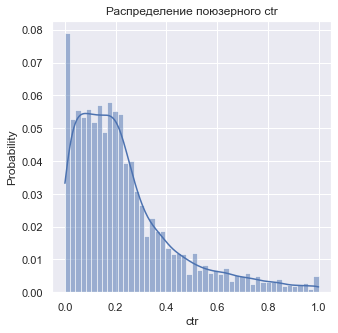

In [324]:
fig, ax = plt.subplots()

sns.histplot(data = df, 
              x='ctr',  
              palette = ['r', 'b'],
              stat='probability',
              alpha=0.5, ax=ax,
              kde=True)
ax.set_title("Распределение поюзерного ctr")


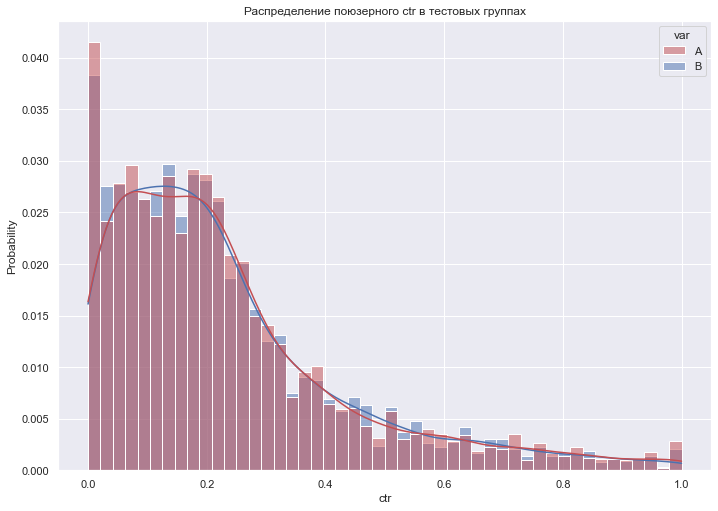

In [57]:
fig, ax = plt.subplots()

sns.histplot(data = df, 
              x='ctr', 
              hue='var', 
              palette = ['r', 'b'],
              stat='probability',
              alpha=0.5, ax=ax,
              kde=True)
ax.set_title("Распределение поюзерного ctr в тестовых группах");


А вот форма распределения CTR достаточно хитрая: если бы не большое количество пользователей с 0 ctr, то можно было бы считать, что распределение по форме ближе к бета распределению. По сути сама по себе природа кликов и показов с равномерным распределением очень странная, обычно все таки наблюдается тяготение значений к определенному числу и скошенность таких распределений. Здесь как будто бы что-то не верно с данными.
Распределение поюзерного CTR имеет похожее на равномерное распределение на двух участках: для невысоких ctr и для высоких ctr

Стандартное отклонение метрики поюзерного ctr  достаточно высокое:

In [59]:
df.ctr.std()

0.20217335708709921

In [139]:
df.ctr.values.mean()

0.2312639283373389

Fitting 106 distributions:  27%|████           | 29/106 [00:21<03:31,  2.75s/it]/Users/viktoria.sinditskaya/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:3866: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  return integrate.quad(llc, _a, x)[0]
Fitting 106 distributions:  28%|████▏          | 30/106 [00:22<03:06,  2.45s/it]/Users/viktoria.sinditskaya/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:3094: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  t1 = integrate.quad(llc, -np.inf, x)[0]
/Users/vi

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
kappa3,7.875411,170.440770,-64583.404526,inf,0.041293,5.327526e-14
genhalflogistic,8.777461,162.421462,-63590.728193,inf,0.041293,5.327555e-14
halflogistic,8.778195,160.393650,-63599.085272,inf,0.041293,5.327534e-14
genexpon,9.160381,160.324860,-63181.603665,inf,0.041293,5.327517e-14
halfgennorm,9.697367,153.586752,-62678.374175,inf,0.041293,5.327531e-14


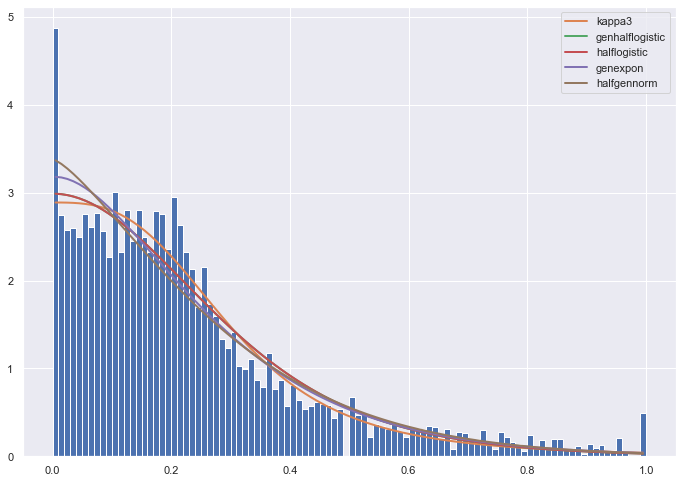

In [90]:
f = Fitter(df.ctr.values)
f.fit()
f.summary()

In [91]:
f.get_best(method = 'sumsquare_error')

{'kappa3': {'a': 2.9772375132397473,
  'loc': -3.8229663481627183e-10,
  'scale': 0.24001260085349735}}

In [92]:
f.fitted_param['genexpon']

(1.4167690345281891,
 1.0457824403488938,
 1.9945637519001191,
 -2.5630954567474387e-12,
 0.44556938877456964)

In [100]:
f.fitted_param['genhalflogistic']

(1.0501428689659692e-07, -1.5182472131933076e-09, 0.1672753935314941)

In [130]:
f.fitted_param['halfgennorm']

(1.346020832992644, -5.34507408814794e-10, 0.32239864518812256)

# Метрика CTR

Чтобы посмотреть, как распределен глобальный CTR используем пуассоновский бутстреп.

In [58]:
bootstrap_conf_level = 0.95

In [29]:
def bootstrap_sample(click, views, n_bootstrap=2000):
    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(click))).astype(np.int64)
    globalCTR = (poisson_bootstraps1*click).sum(axis=1)/(poisson_bootstraps1*views).sum(axis=1)
    return globalCTR

In [40]:
ctr = bootstrap_sample(df.click.values, df.view.values)

In [41]:
left_quant = (1 - bootstrap_conf_level)/2
right_quant = 1 - (1 - bootstrap_conf_level) / 2
quants = pd.DataFrame(ctr).quantile([left_quant, right_quant])

In [42]:
quants

,0
0.025,0.175527
0.975,0.180973


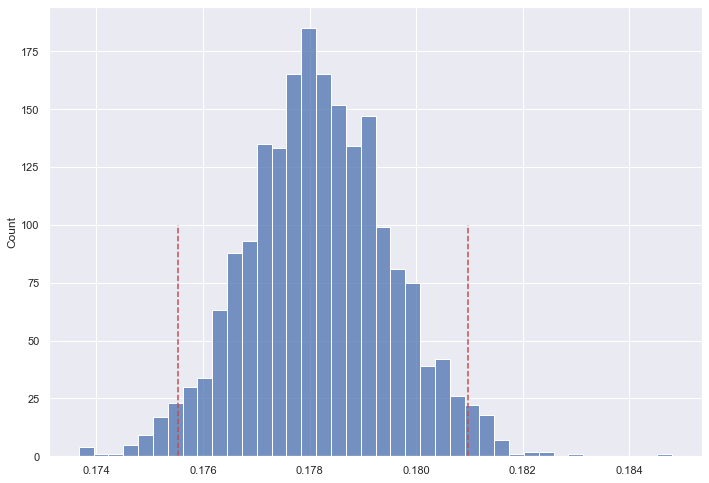

In [48]:
sns.histplot(ctr)
plt.vlines(quants,ymin=0,ymax=100, color='r', linestyle='--')

In [52]:
np.std(ctr), round(np.mean(ctr), 2)

(0.001355075308441539, 0.18)

Очень похоже по графику, что метрика имеет нормальное распределение. Среднее -  0.18 и стандартное отклонение 0.0014. С вероятностью 95% истинное значение CTR  лежит в пределах 0.176 и 0.181.

# Оценка эксперимента по CTR

Для оценки изменения глобального CTR можно применять различные способы. Выбор критерия зависит от вида распределений просмотров и поюзерного ctr, наличия выбросов, сильной скошенности.

Проверим несколько способов: обычный бутстреп, дельта метод (считает дисперсию, учитывая, что события не независимы, что позволяет применять стандартные критерии, используем ttest) и линеаризацию (изменения линеаризованных кликов будут идти в одну сторону с изменением глобального CTR).

Критерием отбора будем использовать FPR и чувствительность.

Данные попробуем сгенерировать самостоятельно, отталкиваясь от распределения фактических выборок.

In [178]:
# для бутстрепа

def bootstrap_two_sample(click1, views1, click2, views2, n_bootstrap=1000):

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(click1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(click2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*click1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*click2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)
    
    boot_data = globalCTR2 - globalCTR1

    p_1 = stats.norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = stats.norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2

    return p_value


In [206]:
# для линеаризации

def linearized_ab(click1,  view1, click2, view2):
    global_ctr_1 = click1.sum()/view1.sum()

    linearized_clicks1 = click1 - global_ctr_1 * view1

    linearized_clicks2 = click2 - global_ctr_1 * view2

    pval = stats.ttest_ind(linearized_clicks1,
                linearized_clicks2,
                equal_var=False).pvalue
    
    return pval

In [211]:
# для дельта метода

def var_ratio(x,y): 
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    var_x = np.var(x,ddof=1)
    var_y = np.var(y,ddof=1)
    cov_xy = np.cov(x,y,ddof=1)[0][1]
    result = (var_x/mean_x**2 + var_y/mean_y**2 - 2*cov_xy/(mean_x*mean_y))*(mean_x*mean_x)/(mean_y*mean_y*len(x))
    return result

def delta_ab(click1,  view1, click2, view2):
    var1 = var_ratio(click1, view1)
    var2 = var_ratio(click2, view2)
    mean_control = click1.sum()/view1.sum()
    mean_treatment = click2.sum()/view2.sum()
    
    diff = mean_treatment - mean_control
    var = var1+var2
    stde = 1.96*np.sqrt(var)
    lower = diff - stde 
    upper = diff + stde
    z = diff/np.sqrt(var)
    pval = stats.norm.sf(abs(z))*2
    return pval



Для того, чтобы рассчитать чувствительность и FPR нужно будет построить процесс генерации данных: просморов, поюзерных CTR, а уже на их основе глобального CTR.  Тестовых групп будем генерировать две -  c  uplift и без него. uplift возьмем невысокий, чтобы чувствительность проверялась в более реалистичных условиях (обычно не меняем CTR на несколько десятков процентов, а 1-5% uplift вполне рабочая ситуация)

### Генерация данных

In [258]:
N = 5000 # размер выборок возьмем сопоставимым с исходным размером
experiments = 1000
uplift = 0.05


In [259]:
viewsA = stats.uniform.rvs(loc=1, scale=df.view.max(), size=N*experiments).astype(np.int64).reshape(experiments, N)
viewsB = stats.uniform.rvs(loc=1, scale=df.view.max(), size=N*experiments).astype(np.int64).reshape(experiments, N)

Text(0.5, 1.0, 'Views, 99%-ile = 116.0  ')

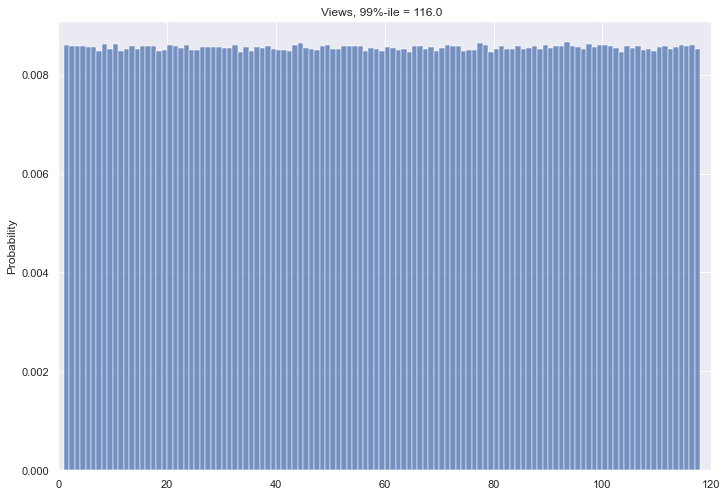

In [159]:
# показы будем генерировать из равномерного распределения

fig = plt.figure()
ax_views = fig.add_subplot()
views_distr = sns.histplot(viewsA.ravel(),  
                           bins=range(0, 120),
                           kde=False,
                           ax=ax_views,
                           stat='probability')
ax_views.set_xlim((0, 120))
views_99_percentile = np.percentile(viewsA.ravel(), 99)
ax_views.set_title(f'Views, 99%-ile = {views_99_percentile:<7.1f}')

Далее сгенерируем данные по поюзерному ctr и используем эти данные для генерации кликов из биномиального распределения.
Так как сам вид распределения и ctr и кликов с просмотрами из задания вызывает вопросы, пока взяла бета-распределение, которым удобно моделировать ratio метрики, и подобрала для него параметры, наиболее подходящие к текущему распределению. Но сгенерированные клики, конечно, получились с другой формой нежели чем клики из задания. И это вроде логично, учитывая форму сгенерированного ctr. Почему в задании клики с равномерным распределением - пока не понятно.

Text(0.5, 1.0, 'Ground truth user CTR, std = 0.194')

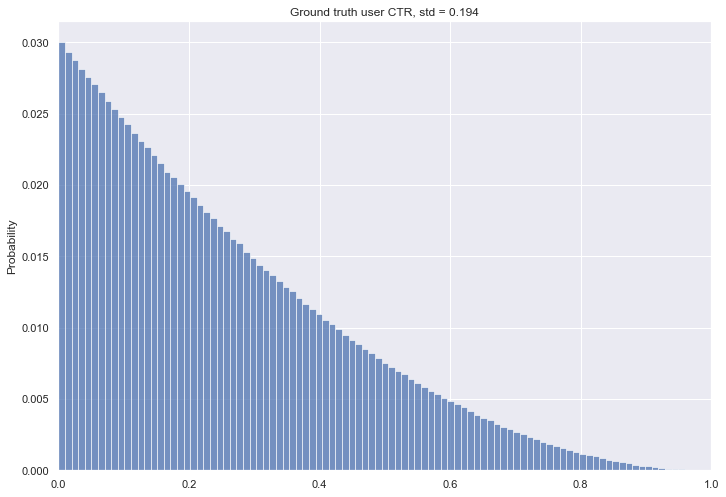

In [260]:

beta = 3
alpha = 1
success_rate = 0.25
alpha_up = success_rate * (1 + uplift) * beta / (1 - success_rate * (1 + uplift) )


success_rate_A = stats.beta(alpha, beta).rvs(
    experiments * N).reshape(experiments, N)

success_rate_B_AA = stats.beta(alpha, beta).rvs(
    experiments * N).reshape(experiments, N)

success_rate_B_AB = stats.beta(alpha_up, beta).rvs(
    experiments * N).reshape(experiments, N)

fig = plt.figure()

ax_ctr = fig.add_subplot()
sns.histplot(success_rate_A.ravel(),
             bins=np.linspace(0, 1, 100),
             ax=ax_ctr,
             kde=False,
             stat='probability')
ax_ctr.set_xlim((0, 1))
success_rate_std = success_rate_A[:10].flatten().std()
ax_ctr.set_title(f'Ground truth user CTR, std = {success_rate_std:2.3f}')

In [261]:
clicks_A = stats.binom.rvs(viewsA, success_rate_A)
clicks_B_AA = stats.binom.rvs(viewsB, success_rate_B_AA)
clicks_B_AB = stats.binom.rvs(viewsB, success_rate_B_AB)



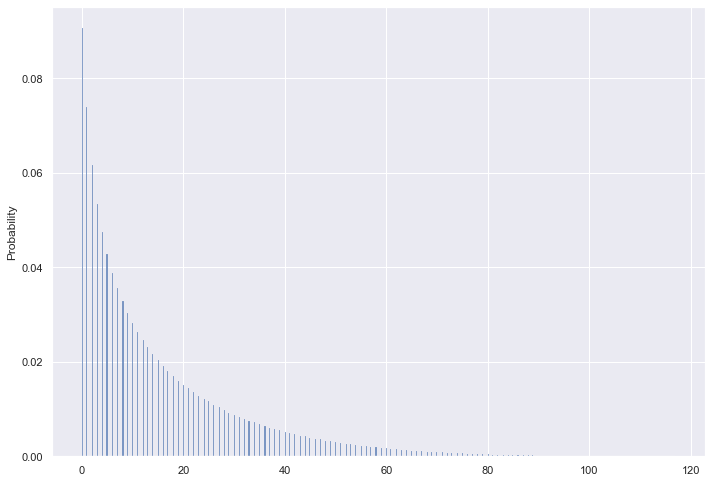

In [262]:
fig = plt.figure()
ax_clicks = fig.add_subplot()
clicks_distr = sns.histplot(clicks_A.ravel(),
                            kde=False,
                            ax=ax_clicks,
                            stat='probability')


#### Считаем FPR для разных способов

In [219]:
boot_pvalues = []
lin_pvalues = []
delta_pvalues = []

for i in tqdm(range(experiments)):
    boot_pvalues.append(bootstrap_two_sample(clicks_A[i], viewsA[i], clicks_B_AA[i], viewsB[i]))
    lin_pvalues.append(linearized_ab(clicks_A[i], viewsA[i], clicks_B_AA[i], viewsB[i]))
    delta_pvalues.append(delta_ab(clicks_A[i], viewsA[i], clicks_B_AA[i], viewsB[i]))

100%|███████████████████████████████████████| 1000/1000 [08:58<00:00,  1.86it/s]


In [284]:
sns.set(rc={'figure.figsize':(5,5)})

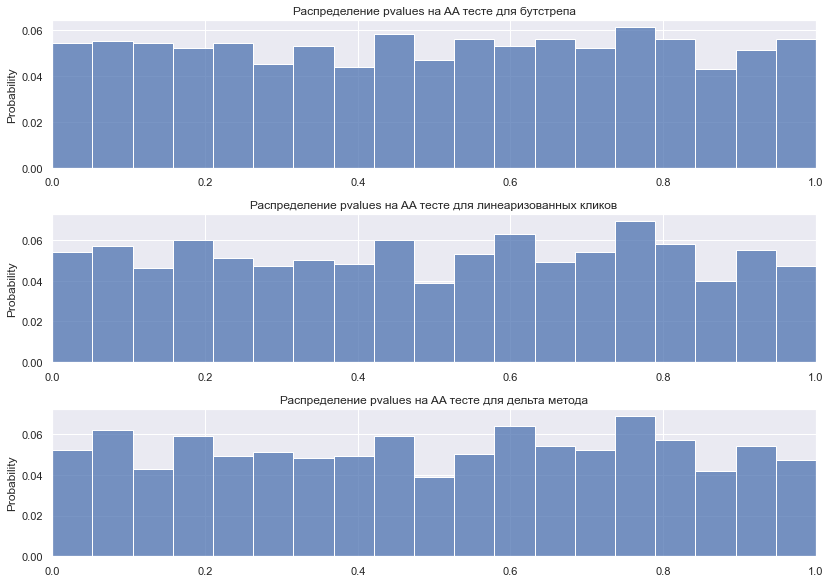

In [221]:
fig, axes = plt.subplots(ncols=1, nrows=3)
p_values_distr_boot = sns.histplot(boot_pvalues,
                 bins=np.linspace(0, 1, 20),
                 kde=False,
                 ax = axes[0],
                 stat='probability')
axes[0].set_xlim((0, 1))
axes[0].set_title('Распределение pvalues на AA тесте для бутстрепа')


p_values_distr_lin = sns.histplot(lin_pvalues, 
                 bins=np.linspace(0, 1, 20),
                 kde=False,
                 ax = axes[1],
                 stat='probability')
axes[1].set_xlim((0, 1))
axes[1].set_title('Распределение pvalues на AA тесте для линеаризованных кликов')


p_values_distr_delta = sns.histplot(delta_pvalues, 
                 bins=np.linspace(0, 1, 20),
                 kde=False,
                 ax = axes[2],
                 stat='probability')
axes[2].set_xlim((0, 1))
axes[2].set_title('Распределение pvalues на AA тесте для дельта метода')

plt.tight_layout()

In [230]:
boot_pvalues = np.array(boot_pvalues)

lin_pvalues = np.array(lin_pvalues)

delta_pvalues = np.array(delta_pvalues)

In [233]:
np.mean(boot_pvalues<0.05)

0.051

In [231]:
np.mean(lin_pvalues<0.05)

0.049

In [234]:
np.mean(delta_pvalues<0.05)

0.049

На сгенерированных данных все три способа тестирования гипотез показали достойный FPR

#### Проверяем чувствительность

In [263]:
boot_pvalues_ab = []
lin_pvalues_ab = []
delta_pvalues_ab = []

for i in tqdm(range(experiments)):
    boot_pvalues_ab.append(bootstrap_two_sample(clicks_A[i], viewsA[i], clicks_B_AB[i], viewsB[i]))
    lin_pvalues_ab.append(linearized_ab(clicks_A[i], viewsA[i], clicks_B_AB[i], viewsB[i]))
    delta_pvalues_ab.append(delta_ab(clicks_A[i], viewsA[i], clicks_B_AB[i], viewsB[i]))

100%|███████████████████████████████████████| 1000/1000 [21:22<00:00,  1.28s/it]


In [268]:
boot_pvalues_ab = np.array(boot_pvalues_ab)

lin_pvalues_ab = np.array(lin_pvalues_ab)

delta_pvalues_ab = np.array(delta_pvalues_ab)

In [272]:
np.mean(boot_pvalues_ab<0.05)



0.779

In [270]:
np.mean(lin_pvalues_ab<0.05)

0.78

In [271]:
np.mean(delta_pvalues_ab<0.05)

0.778

И чувствительность во всех случая тоже почти дотягивает до эталонной в 80%

## Итог

По смоделированным данным все три способа проявили себя хорошо.
Поэтому, чтобы выбрать какой-то один нужно рассмотреть еще и затраты на вычисления. По этому критерию бутстреп не подходит, так как он достаточно долгий.
Я бы остановила свой выбор на дельта методе, потому что по сути он считает данные по исходной метрике CTR, а не использует прокси, как в линеаризации. Но тут конечно нужны дополнительные исследования. 

Также остаются незакрытые вопросы к данными - почему такая нетипичная форма распределения у просмотров/кликов/поюзерного ctr?